In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from utils.inverse_warp import inverse_warp
from utils.sceneflow_util import disp2depth_kitti

def get_visuals(input_dict, output_dict, model_name='scenenet_joint'):

    img_l1_aug = input_dict['input_l1_aug'].detach()
    img_l2_aug = input_dict['input_l2_aug'].detach()
    img_r2_aug = input_dict['input_r2_aug'].detach()
    k_l2_aug = input_dict['input_k_l2_aug'].detach()
    aug_size = input_dict['aug_size']

    sf_b = output_dict['flow_b'][0].detach()
    if model_name == 'scenenet_stereo':
        pose = output_dict['pose_b'].detach()
    else:
        pose = output_dict['pose_b'][0].detach()

    mask = output_dict['mask_l2'][0].detach()
    census_mask = output_dict['census_masks_l2'][0].detach()

    # disparity
    disp_l2 = output_dict['disp_l2'][0].detach()
    _, _, h_dp, w_dp = sf_b.size()
    disp_l2 = disp_l2 * w_dp

    # scene flow
    local_scale = torch.zeros_like(aug_size)
    local_scale[:, 0] = h_dp
    local_scale[:, 1] = w_dp

    pts2, k2_scale, depth = pixel2pts_ms_depth(
        k_l2_aug, disp_l2, local_scale / aug_size)

    _, _, coord2 = pts2pixel_ms(k2_scale, pts2, sf_b, [h_dp, w_dp])
    img_l1_warp = reconstructImg(coord2, img_l1_aug)

    depth_l2 = disp2depth_kitti(disp_l2, k2_scale[:, 0, 0])
    img_l1_warp_cam, _, _, _, _ = inverse_warp(img_l1_aug, depth.squeeze(dim=1), None, k2_scale, torch.inverse(k2_scale), pose_mat=pose)
    
    disp_l2 = disp_l2.cpu().squeeze()
    img_l1_warp = img_l1_warp.cpu().squeeze().permute(1, 2, 0)
    img_l1_warp_cam = img_l1_warp_cam.cpu().squeeze().permute(1, 2, 0)
    mask = mask.cpu().squeeze()
    census_mask = census_mask.cpu().squeeze()
    
    return disp_l2, img_l1_warp, img_l1_warp_cam, mask, census_mask

In [22]:
%autoreload
import torch
import torch.nn as nn
from collections import OrderedDict
from models.SceneNetStereoJointIter import SceneNetStereoJointIter
from models.SceneNetMonoJointIter import SceneNetMonoJointIter
from datasets.kitti_2015_train import KITTI_2015_MonoSceneFlow_Full

from losses_eval import Eval_SceneFlow_KITTI_Test, Eval_SceneFlow_KITTI_Train
from losses import Loss_SceneFlow_SelfSup_JointIter

from augmentations import Augmentation_Resize_Only
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

class Args:
    model_name='scenenet_joint_mono_iter'
    cuda = True
    use_bn = True
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    use_mask = True
    sf_lr_w = 0.0
    pose_lr_w = 0.0
    mask_lr_w = 1.0
    disp_lr_w = 1.0
    disp_pts_w = 0.0
    sf_pts_w = 0.2
    sf_sm_w = 200
    fb_w = 0.2
    pose_sm_w = 200
    pose_pts_w = 0.2
    disp_sm_w = 0.2
    disp_smooth_w = 0.1
    mask_reg_w = 0.2
    encoder_name="pwc"
    static_cons_w = 1.0
    mask_cons_w = 0.2
    mask_sm_w = 0.1
    flow_diff_thresh=1e-3
    evaluation=True

args = Args()

model = SceneNetMonoJointIter(args).cuda()
state_dict = torch.load('pretrained/fb/latest.ckpt')['model']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

augmentation = Augmentation_Resize_Only(args).cuda()

val_dataset = KITTI_2015_MonoSceneFlow_Full(args, root="/external/datasets/kitti2015/")
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1, pin_memory=False)

loss = Eval_SceneFlow_KITTI_Train(args)
train_loss = Loss_SceneFlow_SelfSup_JointIter(args)

RuntimeError: Error(s) in loading state_dict for SceneNetMonoJointIter:
	Missing key(s) in state_dict: "flow_estimators.0.convs.6.0.weight", "flow_estimators.0.convs.6.0.bias", "flow_estimators.0.convs.6.1.weight", "flow_estimators.0.convs.6.1.bias", "flow_estimators.0.convs.6.1.running_mean", "flow_estimators.0.convs.6.1.running_var", "flow_estimators.0.convs.7.0.weight", "flow_estimators.0.convs.7.0.bias", "flow_estimators.0.convs.7.1.weight", "flow_estimators.0.convs.7.1.bias", "flow_estimators.0.convs.7.1.running_mean", "flow_estimators.0.convs.7.1.running_var", "flow_estimators.0.convs_pose.0.weight", "flow_estimators.0.convs_pose.0.bias", "flow_estimators.0.convs_mask.0.weight", "flow_estimators.0.convs_mask.0.bias", "flow_estimators.1.convs.6.0.weight", "flow_estimators.1.convs.6.0.bias", "flow_estimators.1.convs.6.1.weight", "flow_estimators.1.convs.6.1.bias", "flow_estimators.1.convs.6.1.running_mean", "flow_estimators.1.convs.6.1.running_var", "flow_estimators.1.convs.7.0.weight", "flow_estimators.1.convs.7.0.bias", "flow_estimators.1.convs.7.1.weight", "flow_estimators.1.convs.7.1.bias", "flow_estimators.1.convs.7.1.running_mean", "flow_estimators.1.convs.7.1.running_var", "flow_estimators.1.convs_pose.0.weight", "flow_estimators.1.convs_pose.0.bias", "flow_estimators.1.convs_mask.0.weight", "flow_estimators.1.convs_mask.0.bias", "flow_estimators.2.convs.6.0.weight", "flow_estimators.2.convs.6.0.bias", "flow_estimators.2.convs.6.1.weight", "flow_estimators.2.convs.6.1.bias", "flow_estimators.2.convs.6.1.running_mean", "flow_estimators.2.convs.6.1.running_var", "flow_estimators.2.convs.7.0.weight", "flow_estimators.2.convs.7.0.bias", "flow_estimators.2.convs.7.1.weight", "flow_estimators.2.convs.7.1.bias", "flow_estimators.2.convs.7.1.running_mean", "flow_estimators.2.convs.7.1.running_var", "flow_estimators.2.convs_pose.0.weight", "flow_estimators.2.convs_pose.0.bias", "flow_estimators.2.convs_mask.0.weight", "flow_estimators.2.convs_mask.0.bias", "flow_estimators.3.convs.6.0.weight", "flow_estimators.3.convs.6.0.bias", "flow_estimators.3.convs.6.1.weight", "flow_estimators.3.convs.6.1.bias", "flow_estimators.3.convs.6.1.running_mean", "flow_estimators.3.convs.6.1.running_var", "flow_estimators.3.convs.7.0.weight", "flow_estimators.3.convs.7.0.bias", "flow_estimators.3.convs.7.1.weight", "flow_estimators.3.convs.7.1.bias", "flow_estimators.3.convs.7.1.running_mean", "flow_estimators.3.convs.7.1.running_var", "flow_estimators.3.convs_pose.0.weight", "flow_estimators.3.convs_pose.0.bias", "flow_estimators.3.convs_mask.0.weight", "flow_estimators.3.convs_mask.0.bias", "flow_estimators.4.convs.6.0.weight", "flow_estimators.4.convs.6.0.bias", "flow_estimators.4.convs.6.1.weight", "flow_estimators.4.convs.6.1.bias", "flow_estimators.4.convs.6.1.running_mean", "flow_estimators.4.convs.6.1.running_var", "flow_estimators.4.convs.7.0.weight", "flow_estimators.4.convs.7.0.bias", "flow_estimators.4.convs.7.1.weight", "flow_estimators.4.convs.7.1.bias", "flow_estimators.4.convs.7.1.running_mean", "flow_estimators.4.convs.7.1.running_var", "flow_estimators.4.convs_pose.0.weight", "flow_estimators.4.convs_pose.0.bias", "flow_estimators.4.convs_mask.0.weight", "flow_estimators.4.convs_mask.0.bias", "context_networks.convs_pose.0.weight", "context_networks.convs_pose.0.bias". 
	Unexpected key(s) in state_dict: "flow_estimators.0.convs_pose.1.0.weight", "flow_estimators.0.convs_pose.1.0.bias", "flow_estimators.0.convs_pose.1.1.weight", "flow_estimators.0.convs_pose.1.1.bias", "flow_estimators.0.convs_pose.1.1.running_mean", "flow_estimators.0.convs_pose.1.1.running_var", "flow_estimators.0.convs_pose.1.1.num_batches_tracked", "flow_estimators.0.convs_pose.2.0.weight", "flow_estimators.0.convs_pose.2.0.bias", "flow_estimators.0.convs_pose.0.0.weight", "flow_estimators.0.convs_pose.0.0.bias", "flow_estimators.0.convs_pose.0.1.weight", "flow_estimators.0.convs_pose.0.1.bias", "flow_estimators.0.convs_pose.0.1.running_mean", "flow_estimators.0.convs_pose.0.1.running_var", "flow_estimators.0.convs_pose.0.1.num_batches_tracked", "flow_estimators.0.convs_mask.1.0.weight", "flow_estimators.0.convs_mask.1.0.bias", "flow_estimators.0.convs_mask.1.1.weight", "flow_estimators.0.convs_mask.1.1.bias", "flow_estimators.0.convs_mask.1.1.running_mean", "flow_estimators.0.convs_mask.1.1.running_var", "flow_estimators.0.convs_mask.1.1.num_batches_tracked", "flow_estimators.0.convs_mask.2.0.weight", "flow_estimators.0.convs_mask.2.0.bias", "flow_estimators.0.convs_mask.0.0.weight", "flow_estimators.0.convs_mask.0.0.bias", "flow_estimators.0.convs_mask.0.1.weight", "flow_estimators.0.convs_mask.0.1.bias", "flow_estimators.0.convs_mask.0.1.running_mean", "flow_estimators.0.convs_mask.0.1.running_var", "flow_estimators.0.convs_mask.0.1.num_batches_tracked", "flow_estimators.1.convs_pose.1.0.weight", "flow_estimators.1.convs_pose.1.0.bias", "flow_estimators.1.convs_pose.1.1.weight", "flow_estimators.1.convs_pose.1.1.bias", "flow_estimators.1.convs_pose.1.1.running_mean", "flow_estimators.1.convs_pose.1.1.running_var", "flow_estimators.1.convs_pose.1.1.num_batches_tracked", "flow_estimators.1.convs_pose.2.0.weight", "flow_estimators.1.convs_pose.2.0.bias", "flow_estimators.1.convs_pose.0.0.weight", "flow_estimators.1.convs_pose.0.0.bias", "flow_estimators.1.convs_pose.0.1.weight", "flow_estimators.1.convs_pose.0.1.bias", "flow_estimators.1.convs_pose.0.1.running_mean", "flow_estimators.1.convs_pose.0.1.running_var", "flow_estimators.1.convs_pose.0.1.num_batches_tracked", "flow_estimators.1.convs_mask.1.0.weight", "flow_estimators.1.convs_mask.1.0.bias", "flow_estimators.1.convs_mask.1.1.weight", "flow_estimators.1.convs_mask.1.1.bias", "flow_estimators.1.convs_mask.1.1.running_mean", "flow_estimators.1.convs_mask.1.1.running_var", "flow_estimators.1.convs_mask.1.1.num_batches_tracked", "flow_estimators.1.convs_mask.2.0.weight", "flow_estimators.1.convs_mask.2.0.bias", "flow_estimators.1.convs_mask.0.0.weight", "flow_estimators.1.convs_mask.0.0.bias", "flow_estimators.1.convs_mask.0.1.weight", "flow_estimators.1.convs_mask.0.1.bias", "flow_estimators.1.convs_mask.0.1.running_mean", "flow_estimators.1.convs_mask.0.1.running_var", "flow_estimators.1.convs_mask.0.1.num_batches_tracked", "flow_estimators.2.convs_pose.1.0.weight", "flow_estimators.2.convs_pose.1.0.bias", "flow_estimators.2.convs_pose.1.1.weight", "flow_estimators.2.convs_pose.1.1.bias", "flow_estimators.2.convs_pose.1.1.running_mean", "flow_estimators.2.convs_pose.1.1.running_var", "flow_estimators.2.convs_pose.1.1.num_batches_tracked", "flow_estimators.2.convs_pose.2.0.weight", "flow_estimators.2.convs_pose.2.0.bias", "flow_estimators.2.convs_pose.0.0.weight", "flow_estimators.2.convs_pose.0.0.bias", "flow_estimators.2.convs_pose.0.1.weight", "flow_estimators.2.convs_pose.0.1.bias", "flow_estimators.2.convs_pose.0.1.running_mean", "flow_estimators.2.convs_pose.0.1.running_var", "flow_estimators.2.convs_pose.0.1.num_batches_tracked", "flow_estimators.2.convs_mask.1.0.weight", "flow_estimators.2.convs_mask.1.0.bias", "flow_estimators.2.convs_mask.1.1.weight", "flow_estimators.2.convs_mask.1.1.bias", "flow_estimators.2.convs_mask.1.1.running_mean", "flow_estimators.2.convs_mask.1.1.running_var", "flow_estimators.2.convs_mask.1.1.num_batches_tracked", "flow_estimators.2.convs_mask.2.0.weight", "flow_estimators.2.convs_mask.2.0.bias", "flow_estimators.2.convs_mask.0.0.weight", "flow_estimators.2.convs_mask.0.0.bias", "flow_estimators.2.convs_mask.0.1.weight", "flow_estimators.2.convs_mask.0.1.bias", "flow_estimators.2.convs_mask.0.1.running_mean", "flow_estimators.2.convs_mask.0.1.running_var", "flow_estimators.2.convs_mask.0.1.num_batches_tracked", "flow_estimators.3.convs_pose.1.0.weight", "flow_estimators.3.convs_pose.1.0.bias", "flow_estimators.3.convs_pose.1.1.weight", "flow_estimators.3.convs_pose.1.1.bias", "flow_estimators.3.convs_pose.1.1.running_mean", "flow_estimators.3.convs_pose.1.1.running_var", "flow_estimators.3.convs_pose.1.1.num_batches_tracked", "flow_estimators.3.convs_pose.2.0.weight", "flow_estimators.3.convs_pose.2.0.bias", "flow_estimators.3.convs_pose.0.0.weight", "flow_estimators.3.convs_pose.0.0.bias", "flow_estimators.3.convs_pose.0.1.weight", "flow_estimators.3.convs_pose.0.1.bias", "flow_estimators.3.convs_pose.0.1.running_mean", "flow_estimators.3.convs_pose.0.1.running_var", "flow_estimators.3.convs_pose.0.1.num_batches_tracked", "flow_estimators.3.convs_mask.1.0.weight", "flow_estimators.3.convs_mask.1.0.bias", "flow_estimators.3.convs_mask.1.1.weight", "flow_estimators.3.convs_mask.1.1.bias", "flow_estimators.3.convs_mask.1.1.running_mean", "flow_estimators.3.convs_mask.1.1.running_var", "flow_estimators.3.convs_mask.1.1.num_batches_tracked", "flow_estimators.3.convs_mask.2.0.weight", "flow_estimators.3.convs_mask.2.0.bias", "flow_estimators.3.convs_mask.0.0.weight", "flow_estimators.3.convs_mask.0.0.bias", "flow_estimators.3.convs_mask.0.1.weight", "flow_estimators.3.convs_mask.0.1.bias", "flow_estimators.3.convs_mask.0.1.running_mean", "flow_estimators.3.convs_mask.0.1.running_var", "flow_estimators.3.convs_mask.0.1.num_batches_tracked", "flow_estimators.4.convs_pose.1.0.weight", "flow_estimators.4.convs_pose.1.0.bias", "flow_estimators.4.convs_pose.1.1.weight", "flow_estimators.4.convs_pose.1.1.bias", "flow_estimators.4.convs_pose.1.1.running_mean", "flow_estimators.4.convs_pose.1.1.running_var", "flow_estimators.4.convs_pose.1.1.num_batches_tracked", "flow_estimators.4.convs_pose.2.0.weight", "flow_estimators.4.convs_pose.2.0.bias", "flow_estimators.4.convs_pose.0.0.weight", "flow_estimators.4.convs_pose.0.0.bias", "flow_estimators.4.convs_pose.0.1.weight", "flow_estimators.4.convs_pose.0.1.bias", "flow_estimators.4.convs_pose.0.1.running_mean", "flow_estimators.4.convs_pose.0.1.running_var", "flow_estimators.4.convs_pose.0.1.num_batches_tracked", "flow_estimators.4.convs_mask.1.0.weight", "flow_estimators.4.convs_mask.1.0.bias", "flow_estimators.4.convs_mask.1.1.weight", "flow_estimators.4.convs_mask.1.1.bias", "flow_estimators.4.convs_mask.1.1.running_mean", "flow_estimators.4.convs_mask.1.1.running_var", "flow_estimators.4.convs_mask.1.1.num_batches_tracked", "flow_estimators.4.convs_mask.2.0.weight", "flow_estimators.4.convs_mask.2.0.bias", "flow_estimators.4.convs_mask.0.0.weight", "flow_estimators.4.convs_mask.0.0.bias", "flow_estimators.4.convs_mask.0.1.weight", "flow_estimators.4.convs_mask.0.1.bias", "flow_estimators.4.convs_mask.0.1.running_mean", "flow_estimators.4.convs_mask.0.1.running_var", "flow_estimators.4.convs_mask.0.1.num_batches_tracked", "context_networks.convs_pose.1.0.weight", "context_networks.convs_pose.1.0.bias", "context_networks.convs_pose.1.1.weight", "context_networks.convs_pose.1.1.bias", "context_networks.convs_pose.1.1.running_mean", "context_networks.convs_pose.1.1.running_var", "context_networks.convs_pose.1.1.num_batches_tracked", "context_networks.convs_pose.2.0.weight", "context_networks.convs_pose.2.0.bias", "context_networks.convs_pose.0.0.weight", "context_networks.convs_pose.0.0.bias", "context_networks.convs_pose.0.1.weight", "context_networks.convs_pose.0.1.bias", "context_networks.convs_pose.0.1.running_mean", "context_networks.convs_pose.0.1.running_var", "context_networks.convs_pose.0.1.num_batches_tracked", "context_networks.convs_mask.2.0.weight", "context_networks.convs_mask.2.0.bias", "context_networks.convs_mask.0.1.weight", "context_networks.convs_mask.0.1.bias", "context_networks.convs_mask.0.1.running_mean", "context_networks.convs_mask.0.1.running_var", "context_networks.convs_mask.0.1.num_batches_tracked", "context_networks.convs_mask.1.0.weight", "context_networks.convs_mask.1.0.bias", "context_networks.convs_mask.1.1.weight", "context_networks.convs_mask.1.1.bias", "context_networks.convs_mask.1.1.running_mean", "context_networks.convs_mask.1.1.running_var", "context_networks.convs_mask.1.1.num_batches_tracked". 
	size mismatch for flow_estimators.0.convs.1.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for flow_estimators.0.convs.1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.0.convs.1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.0.convs.1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.0.convs.1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.0.convs.1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.0.convs.2.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for flow_estimators.0.convs.3.0.weight: copying a param with shape torch.Size([96, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for flow_estimators.0.convs.3.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.0.convs.3.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.0.convs.3.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.0.convs.3.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.0.convs.3.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.0.convs.4.0.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 128, 3, 3]).
	size mismatch for flow_estimators.0.convs.4.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.5.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3]).
	size mismatch for flow_estimators.0.convs.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.0.convs.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.1.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for flow_estimators.1.convs.1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.1.convs.1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.1.convs.1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.1.convs.1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.1.convs.1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.1.convs.2.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for flow_estimators.1.convs.3.0.weight: copying a param with shape torch.Size([96, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for flow_estimators.1.convs.3.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.1.convs.3.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.1.convs.3.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.1.convs.3.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.1.convs.3.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.1.convs.4.0.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 128, 3, 3]).
	size mismatch for flow_estimators.1.convs.4.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.5.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3]).
	size mismatch for flow_estimators.1.convs.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.1.convs.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.1.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for flow_estimators.2.convs.1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.2.convs.1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.2.convs.1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.2.convs.1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.2.convs.1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.2.convs.2.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for flow_estimators.2.convs.3.0.weight: copying a param with shape torch.Size([96, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for flow_estimators.2.convs.3.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.2.convs.3.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.2.convs.3.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.2.convs.3.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.2.convs.3.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.2.convs.4.0.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 128, 3, 3]).
	size mismatch for flow_estimators.2.convs.4.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.5.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3]).
	size mismatch for flow_estimators.2.convs.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.2.convs.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.1.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for flow_estimators.3.convs.1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.3.convs.1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.3.convs.1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.3.convs.1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.3.convs.1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.3.convs.2.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for flow_estimators.3.convs.3.0.weight: copying a param with shape torch.Size([96, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for flow_estimators.3.convs.3.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.3.convs.3.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.3.convs.3.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.3.convs.3.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.3.convs.3.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.3.convs.4.0.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 128, 3, 3]).
	size mismatch for flow_estimators.3.convs.4.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.5.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3]).
	size mismatch for flow_estimators.3.convs.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.3.convs.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.1.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for flow_estimators.4.convs.1.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.4.convs.1.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.4.convs.1.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.4.convs.1.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.4.convs.1.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for flow_estimators.4.convs.2.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for flow_estimators.4.convs.3.0.weight: copying a param with shape torch.Size([96, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for flow_estimators.4.convs.3.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.4.convs.3.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.4.convs.3.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.4.convs.3.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.4.convs.3.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for flow_estimators.4.convs.4.0.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 128, 3, 3]).
	size mismatch for flow_estimators.4.convs.4.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.4.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.4.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.4.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.4.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.5.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3]).
	size mismatch for flow_estimators.4.convs.5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.5.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.5.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.5.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for flow_estimators.4.convs.5.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for context_networks.convs.0.0.weight: copying a param with shape torch.Size([128, 43, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 43, 3, 3]).
	size mismatch for context_networks.convs.0.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for context_networks.convs.0.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for context_networks.convs.0.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for context_networks.convs.0.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for context_networks.convs.0.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for context_networks.convs.1.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for context_networks.convs_mask.0.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 32, 3, 3]).
	size mismatch for context_networks.convs_mask.0.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1]).

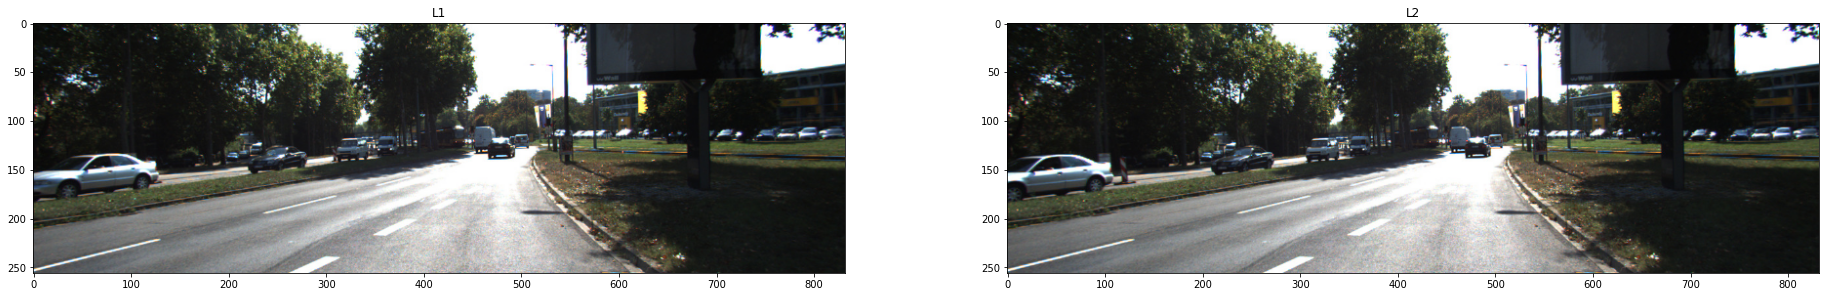

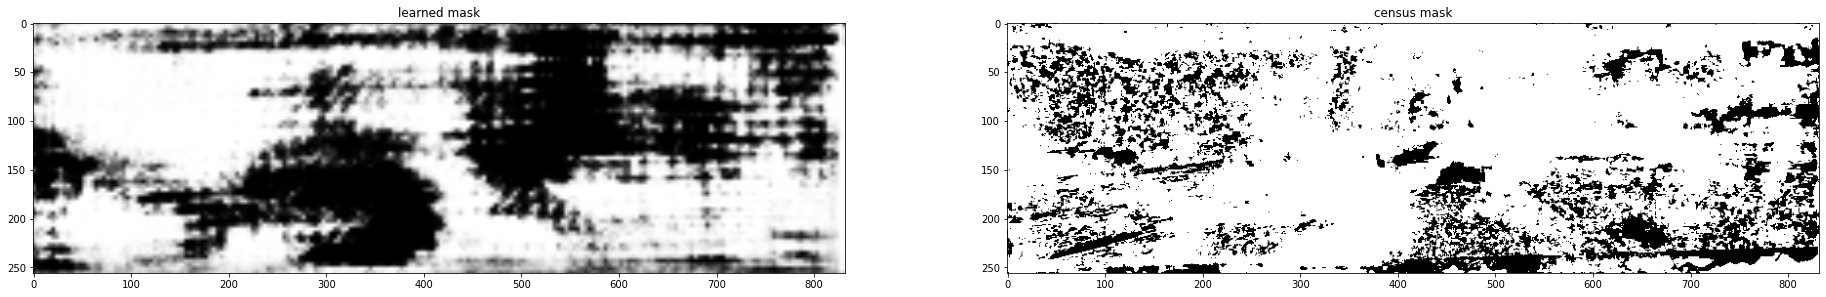

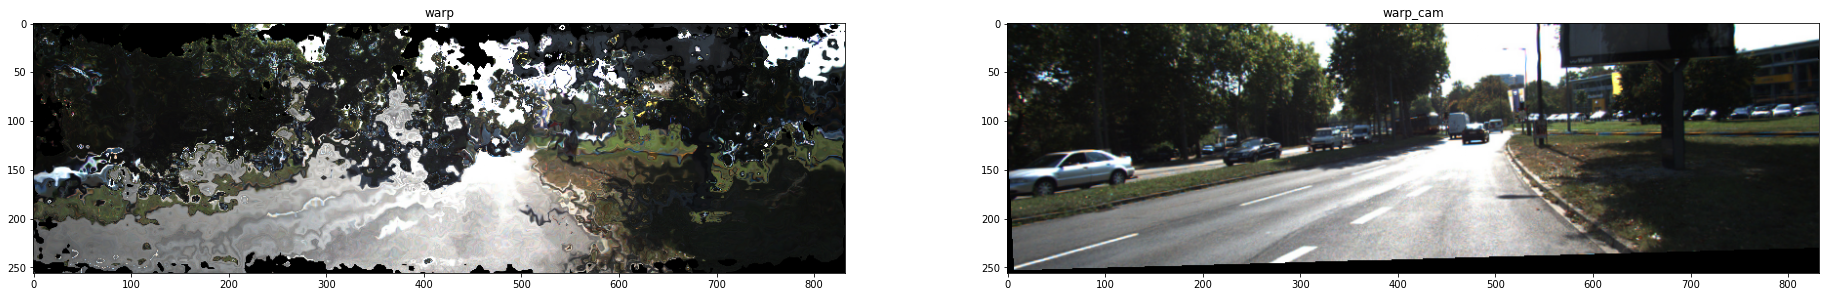

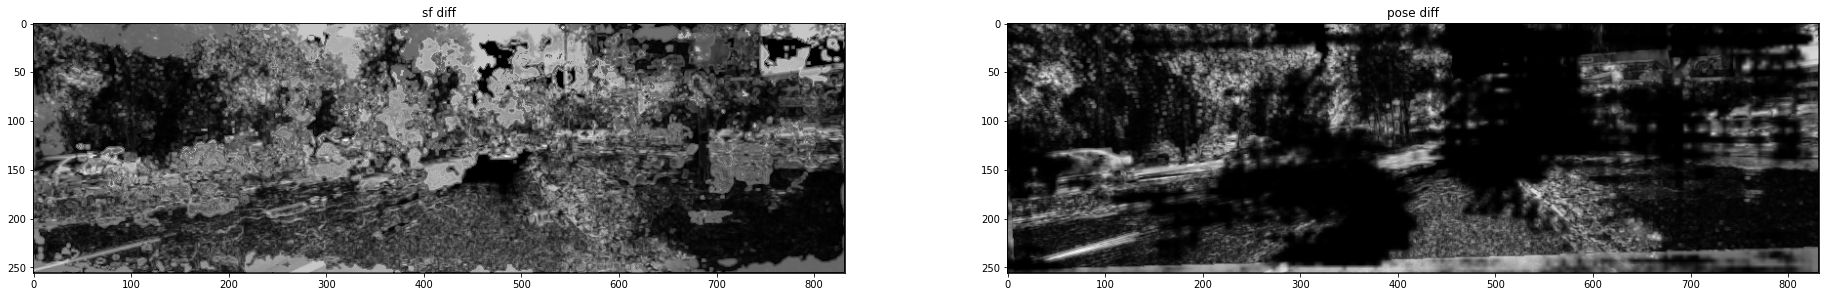

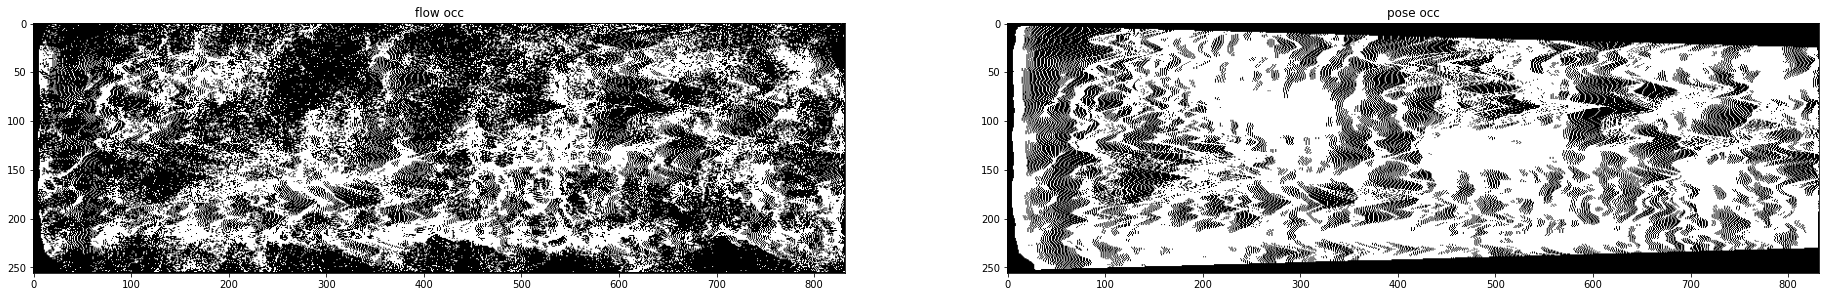

In [23]:
%autoreload

from utils.inverse_warp import pose2flow, pose2sceneflow, inverse_warp
from utils.sceneflow_util import projectSceneFlow2Flow, disp2depth_kitti
from losses import _elementwise_epe, static_cons_loss
from utils.sceneflow_util import pts2pixel_ms, pts2pixel_pose_ms, pixel2pts_ms_depth, reconstructImg
import numpy as np
from models.common import WarpingLayer_Pose

for i, data in enumerate(val_loader):
    with torch.no_grad():
        # Get input and target tensor keys
        input_keys = list(filter(lambda x: "input" in x, data.keys()))
        target_keys = list(filter(lambda x: "target" in x, data.keys()))
        tensor_keys = input_keys + target_keys
        
        # Possibly transfer to Cuda
        for k, v in data.items():
            if k in tensor_keys:
                data[k] = v.cuda(non_blocking=True)
                
        aug_data = augmentation(data)
        out = model(aug_data)
        loss_dict = train_loss(out, data)
        break

disp_l2, img_l1_warp, img_l1_warp_cam, mask, census_mask = get_visuals(data, out)

h, w = disp_l2.shape

disp_l2 = out['disp_l2'][0] * w
disp_l1 = out['disp_l1'][0] * w

img_l1 = data['input_l1_aug'].squeeze().permute(1, 2, 0).cpu()
img_l2 = data['input_l2_aug'].squeeze().permute(1, 2, 0).cpu()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32, 32))
ax1.imshow(img_l1)
ax1.title.set_text('L1')
ax2.imshow(img_l2)
ax2.title.set_text('L2')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(mask, cmap='gray');
ax3.title.set_text('learned mask')
ax4.imshow(census_mask.float(), cmap='gray');
ax4.title.set_text('census mask')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(img_l1_warp);
ax3.title.set_text('warp')
ax4.imshow(img_l1_warp_cam);
ax4.title.set_text('warp_cam')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(out['sf_diffs_b'].cpu().squeeze(), cmap='gray');
ax3.title.set_text('sf diff')
ax4.imshow(out['pose_diffs_b'].cpu().squeeze(), cmap='gray');
ax4.title.set_text('pose diff')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(out['flow_occ_f'].cpu().squeeze(), cmap='gray');
ax3.title.set_text('flow occ')
ax4.imshow(out['pose_occ_f'].cpu().squeeze(), cmap='gray');
ax4.title.set_text('pose occ')

In [13]:
%autoreload

from utils.inverse_warp import pose2flow
from utils.sceneflow_util import projectSceneFlow2Flow
from losses import _elementwise_epe, static_cons_loss
from utils.sceneflow_util import pts2pixel_ms, pts2pixel_pose_ms, pixel2pts_ms_depth, reconstructImg

k_l1_aug = data['input_k_l1_aug'].detach()
k_l2_aug = data['input_k_l2_aug'].detach()
aug_size = data['aug_size']

flow = out['flow_b'][0].detach()
pose = out['pose_b'][0].detach()
disp_l2 = out['disp_l2'][0].detach()
mask_l2 = out['mask_l2'][0].detach()

# disparity
disp_l2 = out['disp_l2'][0].detach()
_, _, h_dp, w_dp = flow.size()
disp_l2 = disp_l2 * w_dp

local_scale = torch.zeros_like(aug_size)
local_scale[:, 0] = h_dp
local_scale[:, 1] = w_dp

pts2, k2_scale, depth = pixel2pts_ms_depth(
    k_l2_aug, disp_l2, local_scale / aug_size)

x = pose2flow(depth.squeeze(dim=1), None, k2_scale, torch.inverse(k2_scale), pose_mat=pose)
y = projectSceneFlow2Flow(k2_scale, flow, disp_l2)
diff = _elementwise_epe(x, y).mean(dim=1)
print(f"l2: {(diff*mask_l2).mean()}")
print(mask_l2.mean())

flow_f = out['flow_f'][0].detach()
pose_f = out['pose_f'][0].detach()
disp_l1 = out['disp_l1'][0].detach()
mask_l1 = out['mask_l1'][0].detach()

pts1, k1_scale, depth = pixel2pts_ms_depth(
    k_l1_aug, disp_l1, local_scale / aug_size)

x = pose2flow(depth.squeeze(dim=1), None, k1_scale, torch.inverse(k1_scale), pose_mat=pose_f)
y = projectSceneFlow2Flow(k1_scale, flow_f, disp_l1)
diff = _elementwise_epe(x, y).mean(dim=1)
print(f"l1: {(diff*mask_l1).mean()}")
print(mask_l1.mean())

l2: 9.132505416870117
tensor(0.9154, device='cuda:0')
l1: 0.9209840297698975
tensor(0.9215, device='cuda:0')


In [37]:
img_l1 = data['input_l1_aug'].squeeze().permute(1, 2, 0).cpu()
img_l2 = data['input_l2_aug'].squeeze().permute(1, 2, 0).cpu()
img_r1 = data['input_r1_aug'].squeeze().permute(1, 2, 0).cpu()
img_r2 = data['input_r2_aug'].squeeze().permute(1, 2, 0).cpu()

disp_l2, img_l1_warp, img_l1_warp_cam, mask, census_mask = get_visuals(data, out)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 16))
ax1.imshow(img_l2)
ax1.title.set_text('L2')
ax2.imshow(img_r2)
ax2.title.set_text('R2')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(16, 16))
ax3.imshow(img_l1)
ax3.title.set_text('L1')
ax4.imshow(img_r1)
ax4.title.set_text('R1')

plt.figure(figsize=(16, 16))
plt.imshow(disp_l2, cmap='plasma')
plt.title('disparity')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32, 32));
ax1.imshow(img_l1_warp);
ax1.title.set_text('scene flow warped')
ax2.imshow(img_l1_warp_cam);
ax2.title.set_text('pose warped')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(mask, cmap='gray');
ax3.title.set_text('learned mask')
ax4.imshow(census_mask, cmap='gray');
ax4.title.set_text('census mask')

NameError: name 'pose_b' is not defined

In [20]:
loss_dict_avg = {}

for i, data in enumerate(tqdm(val_loader)):
    with torch.no_grad():
        # Get input and target tensor keys
        input_keys = list(filter(lambda x: "input" in x, data.keys()))
        target_keys = list(filter(lambda x: "target" in x, data.keys()))
        tensor_keys = input_keys + target_keys
        
        # Possibly transfer to Cuda
        for k, v in data.items():
            if k in tensor_keys:
                data[k] = v.cuda(non_blocking=True)
                
        aug_data = augmentation(data)
        out = model(aug_data)
        loss_dict = loss(out, data)
        
        for k, v in loss_dict.items():
            if k not in loss_dict_avg:
                loss_dict_avg[k] = v
            else:
                loss_dict_avg[k] += v

for k, v in loss_dict_avg.items():
    loss_dict_avg[k] = v / 200;
    
loss_dict_avg

100%|██████████| 200/200 [04:44<00:00,  1.42s/it]
